## Importe

In [18]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
import pyspark  
import os

In [19]:
df = pd.read_csv('startup_data.csv')

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Startup Name            500 non-null    object 
 1   Industry                500 non-null    object 
 2   Funding Rounds          500 non-null    int64  
 3   Funding Amount (M USD)  500 non-null    float64
 4   Valuation (M USD)       500 non-null    float64
 5   Revenue (M USD)         500 non-null    float64
 6   Employees               500 non-null    int64  
 7   Market Share (%)        500 non-null    float64
 8   Profitable              500 non-null    int64  
 9   Year Founded            500 non-null    int64  
 10  Region                  500 non-null    object 
 11  Exit Status             500 non-null    object 
dtypes: float64(4), int64(4), object(4)
memory usage: 47.0+ KB


In [21]:
df.describe()

,Funding Rounds,Funding Amount (M USD),Valuation (M USD),Revenue (M USD),Employees,Market Share (%),Profitable,Year Founded
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,2.958000,152.656760,1371.809180,49.321740,2532.092000,5.092940,0.432000,2006.044000
std,1.440968,86.683711,978.226579,29.267605,1385.434921,2.807646,0.495851,9.347128
min,1.000000,0.570000,2.430000,0.120000,12.000000,0.100000,0.000000,1990.000000
25%,2.000000,79.212500,557.027500,22.802500,1382.750000,2.760000,0.000000,1998.000000
50%,3.000000,156.005000,1222.580000,48.800000,2496.500000,5.135000,0.000000,2006.000000
75%,4.000000,226.450000,2052.085000,74.965000,3708.750000,7.552500,1.000000,2014.000000
max,5.000000,299.810000,4357.490000,99.710000,4984.000000,10.000000,1.000000,2022.000000


# StartUp growth & funding values

## Business Problem

--> Das erkennen von profitablen StartUps

--> Risiko Segmentierung

--> ROI-Prognose (Return Of Investment)

--> Portfolio Strategie

## Warum Data-Science?

-->Weniger Bauchgefühl mehr daten basierte Investitionen!

## 1. Feature engineering

## 1.1 Wo entsteht am meisten Umsatz pro investieretem USD


Umsatz-Effizienz (Revenue / Funding) nach Branche (höher = mehr Umsatz pro investiertem USD):
               Mean_Ratio  Median_Ratio  Count
Industry                                      
HealthTech          3.811         0.378     49
Gaming              2.248         0.304     62
FinTech             1.099         0.294     71
IoT                 0.932         0.290     61
EdTech              0.894         0.325     74
AI                  0.756         0.334     62
E-Commerce          0.620         0.339     70
Cybersecurity       0.562         0.347     51

Umsatz-Effizienz nach Region:
               Mean_Ratio  Median_Ratio  Count
Region                                        
Europe              2.074         0.366    102
South America       1.349         0.300     90
Australia           1.047         0.336    108
North America       1.010         0.296     97
Asia                0.991         0.296    103

Top 10 Startups nach Umsatz-Effizienz:
    Startup Name    Industry        

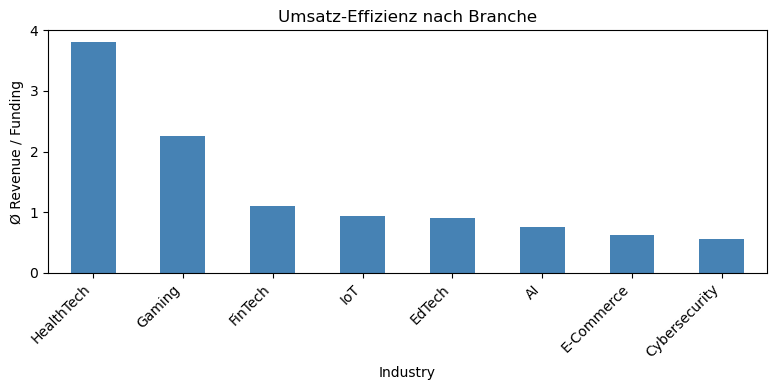

In [22]:
# Frage 1: Wo entsteht am meisten Umsatz pro investiertem USD?
# Kennzahl: Umsatz-Effizienz = Revenue (M USD) / Funding Amount (M USD)

eff_df = df.assign(
    Revenue_per_Invested_USD=df['Revenue (M USD)'] / df['Funding Amount (M USD)']
)

# Aggregation nach Branche und Region
eff_industry = (
    eff_df.groupby('Industry')
    .agg(Mean_Ratio=('Revenue_per_Invested_USD', 'mean'),
         Median_Ratio=('Revenue_per_Invested_USD', 'median'),
         Count=('Revenue_per_Invested_USD', 'size'))
    .sort_values('Mean_Ratio', ascending=False)
    .round(3)
)

eff_region = (
    eff_df.groupby('Region')
    .agg(Mean_Ratio=('Revenue_per_Invested_USD', 'mean'),
         Median_Ratio=('Revenue_per_Invested_USD', 'median'),
         Count=('Revenue_per_Invested_USD', 'size'))
    .sort_values('Mean_Ratio', ascending=False)
    .round(3)
)

# Top 10 einzelne Startups nach Effizienz
top_startups = (
    eff_df[['Startup Name','Industry','Region','Funding Amount (M USD)','Revenue (M USD)','Revenue_per_Invested_USD']]
    .sort_values('Revenue_per_Invested_USD', ascending=False)
    .head(10)
    .round(3)
)

print("Umsatz-Effizienz (Revenue / Funding) nach Branche (höher = mehr Umsatz pro investiertem USD):")
print(eff_industry)
print("\nUmsatz-Effizienz nach Region:")
print(eff_region)
print("\nTop 10 Startups nach Umsatz-Effizienz:")
print(top_startups)

best_industry = eff_industry.index[0]
best_industry_value = eff_industry.iloc[0]['Mean_Ratio']
best_region = eff_region.index[0]
best_region_value = eff_region.iloc[0]['Mean_Ratio']

print(f"\nAntwort: Die höchste durchschnittliche Umsatz-Effizienz liegt in der Branche '{best_industry}' (Ø {best_industry_value:.3f} Umsatz pro investiertem USD).")
print(f"Regional erzielt '{best_region}' die beste Effizienz (Ø {best_region_value:.3f}).")

# Optional: einfache Visualisierung nach Branche
plt.figure(figsize=(8,4))
eff_industry['Mean_Ratio'].plot(kind='bar', color='steelblue')
plt.ylabel('Ø Revenue / Funding')
plt.title('Umsatz-Effizienz nach Branche')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 1.2 Wie verändert sich die Wahrscheinlichkeit zum IPO?


In [23]:
# Berechnung der Wahrscheinlichkeit eines IPOs
ipo_probability = df['Exit Status'].value_counts(normalize=True).get('IPO', 0) * 100

# Ausgabe der Wahrscheinlichkeit
print(f"Die Wahrscheinlichkeit eines IPOs beträgt {ipo_probability:.2f}%.")
# Analyse der IPO-Wahrscheinlichkeit nach relevanten Merkmalen
ipo_flag = (df['Exit Status'] == 'IPO').astype(int)
gdf = df.assign(IPO=ipo_flag)

def rate_table(group, title):
    t = gdf.groupby(group).agg(IPO_Rate=('IPO', 'mean'), n=('IPO', 'size'))
    t['IPO_Rate'] = (t['IPO_Rate'] * 100).round(2)
    print(f"\nIPO-Rate nach {title} (%):")
    print(t.sort_values('IPO_Rate', ascending=False))

rate_table('Industry', 'Branche')
rate_table('Region', 'Region')
rate_table('Profitable', 'Profitabilität')
rate_table('Funding Rounds', 'Finanzierungsrunden')

# Quartile des Finanzierungsvolumens
gdf['Funding Amount Quartil'] = pd.qcut(
    gdf['Funding Amount (M USD)'], 4,
    labels=['Q1 (niedrig)', 'Q2', 'Q3', 'Q4 (hoch)'],
    duplicates='drop'
)
rate_table('Funding Amount Quartil', 'Finanzierungsvolumen (Quartile)')

# Rangkorrelationen zwischen IPO-Outcome und numerischen Variablen
num_cols = [
    'Funding Amount (M USD)', 'Valuation (M USD)', 'Revenue (M USD)',
    'Employees', 'Market Share (%)', 'Funding Rounds', 'Year Founded', 'Profitable'
]
spearman = gdf[num_cols + ['IPO']].corr(method='spearman').loc['IPO'].drop('IPO').sort_values(ascending=False).round(3)
print("\nSpearman-Korrelation mit IPO (positiv = höhere IPO-Wahrscheinlichkeit):")
print(spearman)

Die Wahrscheinlichkeit eines IPOs beträgt 9.00%.

IPO-Rate nach Branche (%):
               IPO_Rate   n
Industry                   
HealthTech        12.24  49
Gaming            11.29  62
E-Commerce        10.00  70
IoT                9.84  61
EdTech             9.46  74
Cybersecurity      7.84  51
AI                 6.45  62
FinTech            5.63  71

IPO-Rate nach Region (%):
               IPO_Rate    n
Region                      
Europe            12.75  102
South America     10.00   90
Australia          8.33  108
North America      7.22   97
Asia               6.80  103

IPO-Rate nach Profitabilität (%):
            IPO_Rate    n
Profitable               
1              11.11  216
0               7.39  284

IPO-Rate nach Finanzierungsrunden (%):
                IPO_Rate    n
Funding Rounds               
5                  11.43  105
4                  10.71   84
2                   8.25   97
3                   7.62  105
1                   7.34  109

IPO-Rate nach Finanzier

/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_25523/2602970966.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = gdf.groupby(group).agg(IPO_Rate=('IPO', 'mean'), n=('IPO', 'size'))


## 1.3 Wie effienzient wird Personal skaliert?

## 1.4 Hebt ein höherer Marktanteil die Bewertung, Profitabilität und Kapital-Effizienz?

Kennzahlen nach Marktanteils-Quantilen:
                      Durchschnitt_Bewertung  Profitabilitaetsrate  \
Market Share Quantil                                                 
Q1 (niedrig)                         1218.20                 38.10   
Q2                                   1333.88                 34.68   
Q3                                   1389.51                 51.20   
Q4 (hoch)                            1546.57                 48.80   

                      Durchschnitt_Kapital_Effizienz    n  
Market Share Quantil                                       
Q1 (niedrig)                                   1.503  126  
Q2                                             0.908  124  
Q3                                             1.394  125  
Q4 (hoch)                                      1.360  125  

Spearman-Korrelation mit Marktanteil (%): (positiv = steigt mit Marktanteil)
Valuation (M USD)           0.106
Profitable                  0.118
Revenue_per_Invested_USD   -0.059

/var/folders/h6/xnldbwzs6z5g_n88vb8sq7j40000gn/T/ipykernel_25523/1111393628.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work_df.groupby('Market Share Quantil')


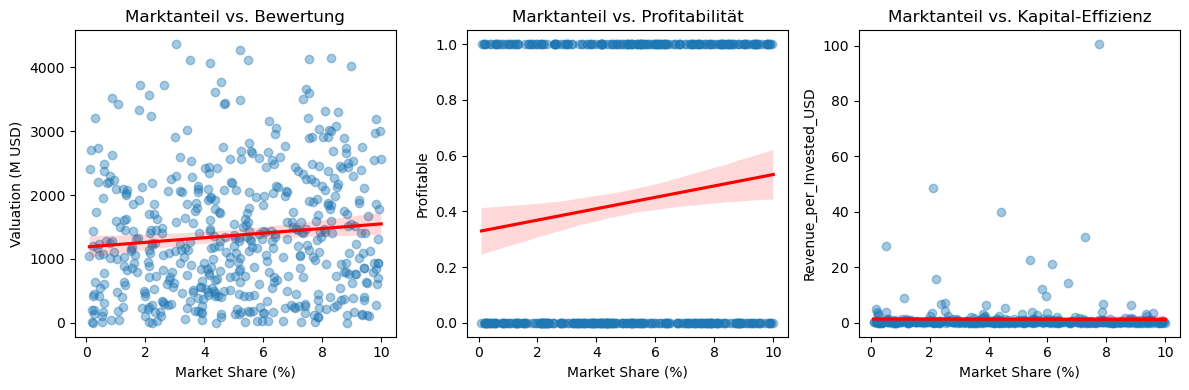

In [24]:
# Analyse 1.3: Zusammenhang Marktanteil vs. Bewertung, Profitabilität und Kapital-Effizienz

# Basis-Daten (Kapital-Effizienz bereits in eff_df enthalten)
work_df = eff_df.copy()

# Quantile des Marktanteils bilden
work_df['Market Share Quantil'] = pd.qcut(
    work_df['Market Share (%)'], 4,
    labels=['Q1 (niedrig)', 'Q2', 'Q3', 'Q4 (hoch)'],
    duplicates='drop'
)

# Aggregation über Marktanteils-Quantile
agg_ms = (
    work_df.groupby('Market Share Quantil')
    .agg(
        Durchschnitt_Bewertung=('Valuation (M USD)', 'mean'),
        Profitabilitaetsrate=('Profitable', 'mean'),
        Durchschnitt_Kapital_Effizienz=('Revenue_per_Invested_USD', 'mean'),
        n=('Startup Name', 'size')
    )
    .assign(
        Profitabilitaetsrate=lambda d: (d['Profitabilitaetsrate']*100).round(2),
        Durchschnitt_Bewertung=lambda d: d['Durchschnitt_Bewertung'].round(2),
        Durchschnitt_Kapital_Effizienz=lambda d: d['Durchschnitt_Kapital_Effizienz'].round(3)
    )
)

print("Kennzahlen nach Marktanteils-Quantilen:")
print(agg_ms)

# Spearman-Korrelationen
vars_for_corr = [
    'Valuation (M USD)', 'Profitable', 'Revenue_per_Invested_USD'
]
spearman_ms = work_df[vars_for_corr + ['Market Share (%)']].corr(method='spearman')['Market Share (%)'].drop('Market Share (%)').round(3)

print("\nSpearman-Korrelation mit Marktanteil (%): (positiv = steigt mit Marktanteil)")
print(spearman_ms)

# Einfache Antwort formulieren
corr_val = spearman_ms['Valuation (M USD)']
corr_prof = spearman_ms['Profitable']
corr_eff = spearman_ms['Revenue_per_Invested_USD']

print("\nAntwort 1.3:")
print(
    f"Höherer Marktanteil zeigt Spearman-Korrelationen: Bewertung={corr_val}, Profitabilität={corr_prof}, Kapital-Effizienz={corr_eff}. "
    "Die Quantilstabelle zeigt, ob obere Marktanteilsgruppen höhere Mittelwerte besitzen. "
    "Interpretation: "
    + ("Bewertung steigt tendenziell. " if corr_val > 0 else "Kein klarer positiver Effekt auf Bewertung. ")
    + ("Profitabilität nimmt leicht zu. " if corr_prof > 0 else "Kein positiver Effekt auf Profitabilität. ")
    + ("Kapital-Effizienz steigt. " if corr_eff > 0 else "Kein positiver Effekt auf Kapital-Effizienz. ")
)

# Optionale Visualisierung: Streudiagramme mit Trendlinien
fig, axs = plt.subplots(1, 3, figsize=(12,4))
sns.regplot(data=work_df, x='Market Share (%)', y='Valuation (M USD)', ax=axs[0], scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axs[0].set_title('Marktanteil vs. Bewertung')

sns.regplot(data=work_df, x='Market Share (%)', y='Profitable', ax=axs[1],
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axs[1].set_title('Marktanteil vs. Profitabilität')

sns.regplot(data=work_df, x='Market Share (%)', y='Revenue_per_Invested_USD', ax=axs[2],
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
axs[2].set_title('Marktanteil vs. Kapital-Effizienz')

plt.tight_layout()
plt.show()

## 2.x Dateninstpektion und Datenqualität

In [ ]:
## Datenqualitätsbewertung der Datei startup_data.csv

**Überblick**
- Zeilen: 500, Spalten: 12 (nach Feature Engineering mehr)
- Keine fehlenden Werte (alle Non-Null Counts = 500 bzw. vollständig in Aggregaten)
- Datentypen konsistent: numerische (int/float) vs. kategoriale (object/category)

**Stärken**
- Vollständigkeit: Keine Missing Values → gut für Modellierung ohne Imputationsschritt.
- Klare Primärentitäten: Jede Zeile scheint ein Startup zu repräsentieren.
- Saubere Kategorien: Industry, Region, Exit Status haben moderate Kardinalität.
- Abgeleitete Metriken wie Revenue_per_Invested_USD sinnvoll ergänzt.

**Auffälligkeiten / potenzielle Risiken**
- Extremwerte bei Revenue_per_Invested_USD (z.B. > 100) deuten auf sehr kleine Funding Beträge mit hohem Umsatz → Outlierprüfung nötig.
- Funding Rounds vs. Funding Amount nicht normalisiert (Skalierung / log-Transformation kann sinnvoll sein).
- Year Founded reicht von 1993 bis 2019 → mögliche Kohorten-/Zeitbias (ältere Firmen haben natürlich höhere Chancen auf bestimmte Exit-Status).
- Profitable als 0/1 binär: Definition prüfen (GAAP? EBITDA?).
- IPO-Anteil nur ca. 9% → Klassen-Ungleichgewicht für Klassifikationsmodelle.
- Market Share (%) relativ niedrige Werte (häufig <10%) → prüfen, ob Messmethode konsistent ist.
- Exit Status "Private"/"Acquired"/"IPO": Reihenfolge / Ordinalität nicht gegeben, korrekt als Kategorie behandeln.
- Nciht alle Kontinente vertreten.
**Vorläufiges Fazit**
Die Datei ist strukturell konsistent und vollständig, aber enthält wahrscheinliche Ausreißer und potenzielle Bias durch Unternehmensalter und Klassenungleichgewicht beim Exit Status. Daten sind gut nutzbar nach Outlier-/Leakage-Prüfung und geeigneter Transformation.